## Data Preprocessing
The ISPRS delivers its data as multiple .tif files. .tif files are popular for storing high quality raster images. Let's take these images and do some preprocessing so that we don't have to repeat these steps every time we want to run a model. 

In [2]:
# Michael Morphew
# takes several TIFF images and arranges them into a single NumPy array for use in TensorFlow

import cv2
import tifffile # for reading tiff files. There are other modules that can do this, but tifffile is most stable on Windows
import numpy as np # for array handling
import matplotlib.pyplot as plt # for QC
import glob # to gather up image filepath lists
from skimage.transform import resize # we're gonna do some rearranging
#import rasterio # let's try to ditch this
import scipy # same

Glob is great. It saves us the pain of manually typing every file name we want to read in. Glob will grab every file name that fulfills the path we hand it. Note how in the cell below we end on a wildcard '\*'. Let's start with the 'top' folders, which contains the false color images. There are two folders, one for train, and one for testing.

In [3]:
top_train_list = glob.glob('./ISPRS/top_train/top_mosaic_09cm_area*')
top_train_list = np.sort(top_train_list)
print(top_train_list)

['./ISPRS/top_train\\top_mosaic_09cm_area1.tif'
 './ISPRS/top_train\\top_mosaic_09cm_area11.tif'
 './ISPRS/top_train\\top_mosaic_09cm_area13.tif'
 './ISPRS/top_train\\top_mosaic_09cm_area15.tif'
 './ISPRS/top_train\\top_mosaic_09cm_area17.tif'
 './ISPRS/top_train\\top_mosaic_09cm_area21.tif'
 './ISPRS/top_train\\top_mosaic_09cm_area23.tif'
 './ISPRS/top_train\\top_mosaic_09cm_area26.tif'
 './ISPRS/top_train\\top_mosaic_09cm_area28.tif'
 './ISPRS/top_train\\top_mosaic_09cm_area3.tif'
 './ISPRS/top_train\\top_mosaic_09cm_area30.tif'
 './ISPRS/top_train\\top_mosaic_09cm_area32.tif'
 './ISPRS/top_train\\top_mosaic_09cm_area34.tif'
 './ISPRS/top_train\\top_mosaic_09cm_area37.tif'
 './ISPRS/top_train\\top_mosaic_09cm_area5.tif'
 './ISPRS/top_train\\top_mosaic_09cm_area7.tif']


In [4]:
top_test_list = glob.glob('./ISPRS/top_test/top_mosaic_09cm_area*')
top_test_list = np.sort(top_test_list)
print(top_test_list)

['./ISPRS/top_test\\top_mosaic_09cm_area10.tif'
 './ISPRS/top_test\\top_mosaic_09cm_area12.tif'
 './ISPRS/top_test\\top_mosaic_09cm_area14.tif'
 './ISPRS/top_test\\top_mosaic_09cm_area16.tif'
 './ISPRS/top_test\\top_mosaic_09cm_area2.tif'
 './ISPRS/top_test\\top_mosaic_09cm_area20.tif'
 './ISPRS/top_test\\top_mosaic_09cm_area22.tif'
 './ISPRS/top_test\\top_mosaic_09cm_area24.tif'
 './ISPRS/top_test\\top_mosaic_09cm_area27.tif'
 './ISPRS/top_test\\top_mosaic_09cm_area29.tif'
 './ISPRS/top_test\\top_mosaic_09cm_area31.tif'
 './ISPRS/top_test\\top_mosaic_09cm_area33.tif'
 './ISPRS/top_test\\top_mosaic_09cm_area35.tif'
 './ISPRS/top_test\\top_mosaic_09cm_area38.tif'
 './ISPRS/top_test\\top_mosaic_09cm_area4.tif'
 './ISPRS/top_test\\top_mosaic_09cm_area6.tif'
 './ISPRS/top_test\\top_mosaic_09cm_area8.tif']


Sanity check - let's plot a couple of them and make sure they look like what we think they should like it

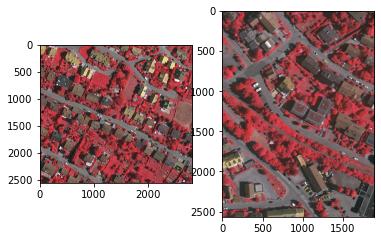

In [6]:
img0 = tifffile.imread('./ISPRS/top_train/top_mosaic_09cm_area13.tif') # grab a random image, can be any one.
img1 = tifffile.imread('./ISPRS/top_train/top_mosaic_09cm_area11.tif') # grab a second random image
fig, axes = plt.subplots(1,2) # one row, two columns
axes[0].imshow(img0)
axes[1].imshow(img1)

Oh no! Our images are all different sizes, but our neural network will only accept one input image size. There's a couple solutions. The more robust solution would be to use something like a sliding window, where the neural network accepts only parts of the image at a time. This would take a bit of time to set up. We would need to determine the appropriate amount of padding for each image so that we could run predictions properly. This is not a hard task by any means, but in the spirit of keeping things simple, we'll use another solution. Instead, we'll resize our images to a common size. For images that have greatly varying sizes, this will lead to distortion in the aspect ratio which could affect training and prediction. Let's assume those effects to be minimal for this first pass.

In [9]:
imgResize = 512
top_train_total = np.zeros((len(top_train_list), imgResize, imgResize, 3)) 
# we create an array that has the shape NWHC: sample number, height, width, channel
top_test_total = np.zeros((len(top_test_list), imgResize, imgResize, 3)) 

In [10]:
for i in range(len(top_train_list)):
    img = tifffile.imread(top_train_list[i]) # read the image
    img_reshaped = resize(img, (imgResize, imgResize, 3)) # resize it
    top_train_total[i] = img_reshaped # add it to the array

In [11]:
for i in range(len(top_test_list)):
    img = tifffile.imread(top_test_list[i]) # read the image
    img_reshaped = resize(img, (imgResize, imgResize, 3)) # resize it
    top_test_total[i] = img_reshaped # add it to the array

Alright, we've handled the false color images. Now let's move onto the DSM images. We'll follow a similar process that we did for the top folder.

In [13]:
dsm_train_list = glob.glob('./ISPRS/dsm_train/dsm_09cm_matching_area*.tif')
dsm_train_list = np.sort(dsm_train_list)
print(dsm_train_list)

['./ISPRS/dsm_train\\dsm_09cm_matching_area1.tif'
 './ISPRS/dsm_train\\dsm_09cm_matching_area11.tif'
 './ISPRS/dsm_train\\dsm_09cm_matching_area13.tif'
 './ISPRS/dsm_train\\dsm_09cm_matching_area15.tif'
 './ISPRS/dsm_train\\dsm_09cm_matching_area17.tif'
 './ISPRS/dsm_train\\dsm_09cm_matching_area21.tif'
 './ISPRS/dsm_train\\dsm_09cm_matching_area23.tif'
 './ISPRS/dsm_train\\dsm_09cm_matching_area26.tif'
 './ISPRS/dsm_train\\dsm_09cm_matching_area28.tif'
 './ISPRS/dsm_train\\dsm_09cm_matching_area3.tif'
 './ISPRS/dsm_train\\dsm_09cm_matching_area30.tif'
 './ISPRS/dsm_train\\dsm_09cm_matching_area32.tif'
 './ISPRS/dsm_train\\dsm_09cm_matching_area34.tif'
 './ISPRS/dsm_train\\dsm_09cm_matching_area37.tif'
 './ISPRS/dsm_train\\dsm_09cm_matching_area5.tif'
 './ISPRS/dsm_train\\dsm_09cm_matching_area7.tif']


In [14]:
dsm_test_list = glob.glob('./ISPRS/dsm_test/dsm_09cm_matching_area*.tif')
dsm_test_list = np.sort(dsm_test_list)
print(dsm_test_list)

['./ISPRS/dsm_test\\dsm_09cm_matching_area10.tif'
 './ISPRS/dsm_test\\dsm_09cm_matching_area12.tif'
 './ISPRS/dsm_test\\dsm_09cm_matching_area14.tif'
 './ISPRS/dsm_test\\dsm_09cm_matching_area16.tif'
 './ISPRS/dsm_test\\dsm_09cm_matching_area2.tif'
 './ISPRS/dsm_test\\dsm_09cm_matching_area20.tif'
 './ISPRS/dsm_test\\dsm_09cm_matching_area22.tif'
 './ISPRS/dsm_test\\dsm_09cm_matching_area24.tif'
 './ISPRS/dsm_test\\dsm_09cm_matching_area27.tif'
 './ISPRS/dsm_test\\dsm_09cm_matching_area29.tif'
 './ISPRS/dsm_test\\dsm_09cm_matching_area31.tif'
 './ISPRS/dsm_test\\dsm_09cm_matching_area33.tif'
 './ISPRS/dsm_test\\dsm_09cm_matching_area35.tif'
 './ISPRS/dsm_test\\dsm_09cm_matching_area38.tif'
 './ISPRS/dsm_test\\dsm_09cm_matching_area4.tif'
 './ISPRS/dsm_test\\dsm_09cm_matching_area6.tif'
 './ISPRS/dsm_test\\dsm_09cm_matching_area8.tif']


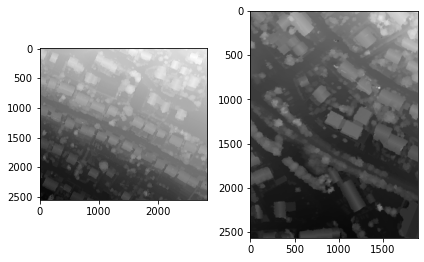

In [15]:
img0 = tifffile.imread('./ISPRS/dsm_train/dsm_09cm_matching_area13.tif') # grab a random image, can be any one.
img1 = tifffile.imread('./ISPRS/dsm_train/dsm_09cm_matching_area11.tif') # grab a second random image
fig, axes = plt.subplots(1,2) # one row, two columns
axes[0].imshow(img0, cmap='gray')
axes[1].imshow(img1, cmap='gray')
fig.tight_layout()

The second image looks perhaps passible, but the first image shows a clear flaw with the DSM. There is a massive terrain effect. The purpose of the DSM is to determine the relative heights of objects in the false color image. For example, this would help with classifying trees vs. low vegetation. Both will have similar appearances on the false color image but different appearances on the DSM. We need to normalize these DSMs for them to be useful.

Some light googling on normalized DSMs shows that "white top-hat transforms" are the operator of choice for removing the terrain effect. We have a couple options. We can either load these .tiff files into something like ArcGIS or QGIS, programs that have native operations. These programs probably have really robust transforms for taking care of the terrain. The other option is to approximate the transformation. The opencv package provides a lot of options for image manipulation, including top-hat transformations. I've borrowed some boilerplate code from this link: https://www.geeksforgeeks.org/top-hat-and-black-hat-transform-using-python-opencv/. The link also explains the transformation in a little bit more detail if it still feels a little too much like a black box.

The only parameter that we really need tweak is the filter size. If the filter size is too small, it won't treat objects in the scene as interesting features. If the filter size is too large, some background will get preserved.

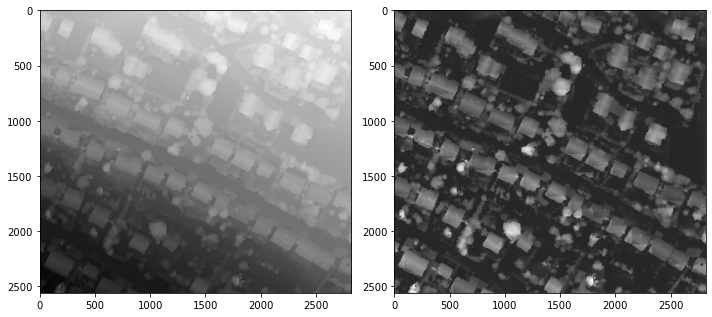

In [16]:
# Getting the kernel to be used in Top-Hat
filterSize = 200
filterSize =(filterSize, filterSize) 
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,  
                                   filterSize) 
  
# Applying the Top-Hat operation 
tophat_img = cv2.morphologyEx(img0,  
                              cv2.MORPH_TOPHAT, 
                              kernel) 
  
fig, axes = plt.subplots(1,2, figsize=(10,10)) # one row, two columns
axes[0].imshow(img0, cmap='gray')
axes[1].imshow(tophat_img, cmap='gray')
fig.tight_layout()

Once you're happy with how the filtersize paramter is tweaked, we can go ahead and run the operation on all the DSMs before reshaping them and packing them into a .npy file.

In [17]:
dsm_train_total = np.zeros((len(dsm_train_list), imgResize, imgResize, 1))
for i in range(len(dsm_train_list)):
    img = tifffile.imread(dsm_train_list[i])
    tophat_img = cv2.morphologyEx(img,  
                              cv2.MORPH_TOPHAT, 
                              kernel) 
    img_reshaped = resize(tophat_img, (imgResize, imgResize, 1))
    dsm_train_total[i] = img_reshaped


In [18]:
dsm_test_total = np.zeros((len(dsm_test_list), imgResize, imgResize, 1))
for i in range(len(dsm_test_list)):
    img = tifffile.imread(dsm_test_list[i])
    tophat_img = cv2.morphologyEx(img,  
                              cv2.MORPH_TOPHAT, 
                              kernel) 
    img_reshaped = resize(tophat_img, (imgResize, imgResize, 1))
    dsm_test_total[i] = img_reshaped

Great, now that we have both pieces, let's pack it all together.

In [19]:
data_train_total = np.concatenate((top_train_total, dsm_train_total), axis=-1)
data_test_total = np.concatenate((top_test_total, dsm_test_total), axis=-1)

In [20]:
np.save('data_train.npy', data_train_total)
np.save('data_test.npy', data_test_total)

The final piece are the labels. Let's load them in and understand what they look like.

In [24]:
label_train_list = glob.glob('./ISPRS/gt_train/top_mosaic_09cm_area*')
label_train_list = np.sort(label_train_list)
print(label_train_list)

['./ISPRS/gt_train\\top_mosaic_09cm_area1.tif'
 './ISPRS/gt_train\\top_mosaic_09cm_area11.tif'
 './ISPRS/gt_train\\top_mosaic_09cm_area13.tif'
 './ISPRS/gt_train\\top_mosaic_09cm_area15.tif'
 './ISPRS/gt_train\\top_mosaic_09cm_area17.tif'
 './ISPRS/gt_train\\top_mosaic_09cm_area21.tif'
 './ISPRS/gt_train\\top_mosaic_09cm_area23.tif'
 './ISPRS/gt_train\\top_mosaic_09cm_area26.tif'
 './ISPRS/gt_train\\top_mosaic_09cm_area28.tif'
 './ISPRS/gt_train\\top_mosaic_09cm_area3.tif'
 './ISPRS/gt_train\\top_mosaic_09cm_area30.tif'
 './ISPRS/gt_train\\top_mosaic_09cm_area32.tif'
 './ISPRS/gt_train\\top_mosaic_09cm_area34.tif'
 './ISPRS/gt_train\\top_mosaic_09cm_area37.tif'
 './ISPRS/gt_train\\top_mosaic_09cm_area5.tif'
 './ISPRS/gt_train\\top_mosaic_09cm_area7.tif']


In [25]:
label_test_list = glob.glob('./ISPRS/gt_test/top_mosaic_09cm_area*')
label_test_list = np.sort(label_test_list)
print(label_test_list)

['./ISPRS/gt_test\\top_mosaic_09cm_area10.tif'
 './ISPRS/gt_test\\top_mosaic_09cm_area12.tif'
 './ISPRS/gt_test\\top_mosaic_09cm_area14.tif'
 './ISPRS/gt_test\\top_mosaic_09cm_area16.tif'
 './ISPRS/gt_test\\top_mosaic_09cm_area2.tif'
 './ISPRS/gt_test\\top_mosaic_09cm_area20.tif'
 './ISPRS/gt_test\\top_mosaic_09cm_area22.tif'
 './ISPRS/gt_test\\top_mosaic_09cm_area24.tif'
 './ISPRS/gt_test\\top_mosaic_09cm_area27.tif'
 './ISPRS/gt_test\\top_mosaic_09cm_area29.tif'
 './ISPRS/gt_test\\top_mosaic_09cm_area31.tif'
 './ISPRS/gt_test\\top_mosaic_09cm_area33.tif'
 './ISPRS/gt_test\\top_mosaic_09cm_area35.tif'
 './ISPRS/gt_test\\top_mosaic_09cm_area38.tif'
 './ISPRS/gt_test\\top_mosaic_09cm_area4.tif'
 './ISPRS/gt_test\\top_mosaic_09cm_area6.tif'
 './ISPRS/gt_test\\top_mosaic_09cm_area8.tif']


In [26]:
img = tifffile.imread(label_train_list[0])
print(img.shape)

(2569, 1919, 3)


The height and width appear correct, but how are the labels put into these three channels? Let's do some plotting and see if we can't create our mapping.

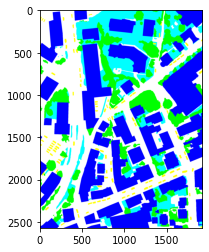

In [27]:
plt.figure() # one row, two columns
plt.imshow(img)

Ah, it's an RGB image, where every color denotes a different class. This is great for plotting purposes, but as far as machine learning goes, it's usually better to one-hot encode our labels. For each of our five classes (plus the background), we will create separate channels. Each channel will isolate one of the classes from the others, with a value of 1 denoting where that class is, and 0 denoting everywhere else. For example, in the "buildings" channel, we would only see buildings (marked by 1's). The impervious surfaces (roads), trees, cars, and vegetation would all blend together.

In this way, every class is separated and can almost be treated like its own binary problem. Of course, the machine learning model will need to learn how to balance the classes, but for the purpose of reading in the labels, one-hot encoding is easiest.

Let's start by reshaping our labels.

In [28]:
rgb_label_train_total = np.zeros((len(label_train_list), imgResize, imgResize, 3))
for i in range(len(label_train_list)):
    img = tifffile.imread(label_train_list[i])
    img_reshaped = resize(img, (imgResize, imgResize, 3))
    rgb_label_train_total[i] = img_reshaped

In [29]:
rgb_label_test_total = np.zeros((len(label_test_list), imgResize, imgResize, 3))
for i in range(len(label_test_list)):
    img = tifffile.imread(label_test_list[i])
    img_reshaped = resize(img, (imgResize, imgResize, 3))
    rgb_label_test_total[i] = img_reshaped

The reshaping process image might have accidentally interpolated some classes at the edges, so we must make sure that they are all integers before one-hot encoding them. A simple threshold of 0.5 will achieve this. We'll also specify that our final array has the integer type.

In [30]:
rgb_label_train_total[rgb_label_train_total>=0.5] = 1
rgb_label_train_total[rgb_label_train_total<0.5] = 0
rgb_label_test_total[rgb_label_test_total>=0.5] = 1
rgb_label_test_total[rgb_label_test_total<0.5] = 0

In [31]:
onehot_label_train_total = np.zeros((len(label_train_list),imgResize,imgResize,6), dtype=np.uint8)
for k in range(len(label_train_list)):
    for i in range(imgResize):
        for j in range(imgResize):
            # impervious surface
            if(rgb_label_train_total[k,i,j,0]==1 and rgb_label_train_total[k,i,j,1]==1 and rgb_label_train_total[k,i,j,2]==1):
                onehot_label_train_total[k,i,j,0]=1
            # building
            elif(rgb_label_train_total[k,i,j,0]==0 and rgb_label_train_total[k,i,j,1]==0 and rgb_label_train_total[k,i,j,2]==1):
                onehot_label_train_total[k,i,j,1]=1
            # low vegetation
            elif(rgb_label_train_total[k,i,j,0]==0 and rgb_label_train_total[k,i,j,1]==1 and rgb_label_train_total[k,i,j,2]==1):
                onehot_label_train_total[k,i,j,2]=1
            # tree
            elif(rgb_label_train_total[k,i,j,0]==0 and rgb_label_train_total[k,i,j,1]==1 and rgb_label_train_total[k,i,j,2]==0):
                onehot_label_train_total[k,i,j,3]=1
            # car
            elif(rgb_label_train_total[k,i,j,0]==1 and rgb_label_train_total[k,i,j,1]==1 and rgb_label_train_total[k,i,j,2]==0):
                onehot_label_train_total[k,i,j,4]=1
            # clutter/background
            elif(rgb_label_train_total[k,i,j,0]==1 and rgb_label_train_total[k,i,j,1]==0 and rgb_label_train_total[k,i,j,2]==0):
                onehot_label_train_total[k,i,j,5]=1
                

In [32]:
onehot_label_test_total = np.zeros((len(label_test_list),imgResize,imgResize,6), dtype=np.uint8)
for k in range(len(label_test_list)):
    for i in range(imgResize):
        for j in range(imgResize):
            # impervious surface
            if(rgb_label_test_total[k,i,j,0]==1 and rgb_label_test_total[k,i,j,1]==1 and rgb_label_test_total[k,i,j,2]==1):
                onehot_label_test_total[k,i,j,0]=1
            # building
            elif(rgb_label_test_total[k,i,j,0]==0 and rgb_label_test_total[k,i,j,1]==0 and rgb_label_test_total[k,i,j,2]==1):
                onehot_label_test_total[k,i,j,1]=1
            # low vegetation
            elif(rgb_label_test_total[k,i,j,0]==0 and rgb_label_test_total[k,i,j,1]==1 and rgb_label_test_total[k,i,j,2]==1):
                onehot_label_test_total[k,i,j,2]=1
            # tree
            elif(rgb_label_test_total[k,i,j,0]==0 and rgb_label_test_total[k,i,j,1]==1 and rgb_label_test_total[k,i,j,2]==0):
                onehot_label_test_total[k,i,j,3]=1
            # car
            elif(rgb_label_test_total[k,i,j,0]==1 and rgb_label_test_total[k,i,j,1]==1 and rgb_label_test_total[k,i,j,2]==0):
                onehot_label_test_total[k,i,j,4]=1
            # clutter/background
            elif(rgb_label_test_total[k,i,j,0]==1 and rgb_label_test_total[k,i,j,1]==0 and rgb_label_test_total[k,i,j,2]==0):
                onehot_label_test_total[k,i,j,5]=1
   

We've done some significant changes to our labels, so let's plot them just to be sure that nothing got messed up. We'll also print the unique values in the label array. We should see only 0 and 1. 

[0 1]


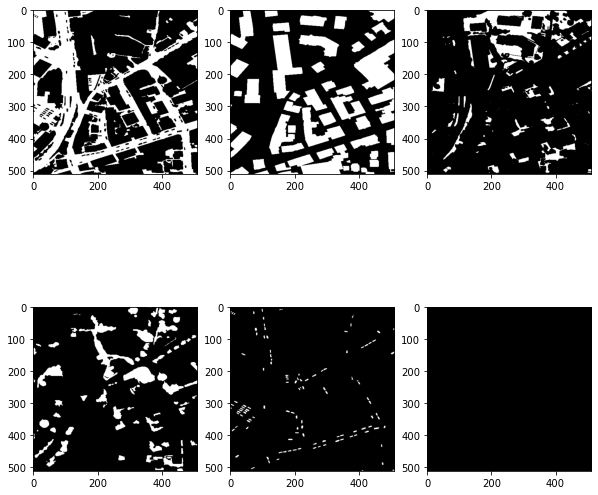

In [33]:
fig, axes = plt.subplots(2, 3, figsize=(10,10))
axes[0,0].imshow(onehot_label_train_total[0,:,:,0], cmap='gray')
axes[0,1].imshow(onehot_label_train_total[0,:,:,1], cmap='gray')
axes[0,2].imshow(onehot_label_train_total[0,:,:,2], cmap='gray')
axes[1,0].imshow(onehot_label_train_total[0,:,:,3], cmap='gray')
axes[1,1].imshow(onehot_label_train_total[0,:,:,4], cmap='gray')
axes[1,2].imshow(onehot_label_train_total[0,:,:,5], cmap='gray')
print(np.unique(onehot_label_train_total))

Great, this is looking good. Depending on the monitor you're using, you may see some gray values, but this is just due to matplotlib's plotting function doing some interpolation of its own. The array itself checks out. Let's save out this array. 

In [34]:
np.save('label_train.npy', onehot_label_train_total)
np.save('label_test.npy', onehot_label_test_total)

Alright, we've finished preprocessing! We can now begin the ML process in "Urban_remote_sensing" notebook.